# Portfolio Risk Analyser
Used historical equity price data for Apple (AAPL), Microsoft(MSFT), and Google (GOOGL)

## 1. Installing Data

In [1]:
!pip -q install yfinance

## 2. Importing Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 3. Adding Stocks and Weights



In [3]:
tickers = ["AAPL", "MSFT", "GOOGL"]
START = "2020-01-01"
END   = "2025-01-01"

weights = np.array([1/3, 1/3, 1/3])

## 4. Downloading Stock Data

In [4]:
data = {}

for t in tickers:
    df = yf.download(t, start=START, end=END, auto_adjust=True)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    data[t] = df.dropna()

for t in tickers:
    print(f"\n================ {t} =================")
    display(data[t].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================ AAPL =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.468262,72.528582,71.223259,71.476600,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335571,72.374177,70.634554,70.885487,118387200
2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200



================ MSFT =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,152.505692,152.610135,150.331386,150.758649,22622100
2020-01-03,150.606735,151.869547,150.075028,150.321902,21116200
2020-01-06,150.996002,151.062473,148.603305,149.144517,20813700
2020-01-07,149.619263,151.603675,149.372403,151.271365,21634100
2020-01-08,152.002487,152.676625,149.970597,150.901085,27746500



================ GOOGL =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,67.920807,67.920807,66.819630,66.914911,27278000
2020-01-03,67.565498,68.172416,66.860824,66.894573,23408000
2020-01-06,69.366386,69.391693,67.043438,67.074696,46768000
2020-01-07,69.232407,69.648763,69.056240,69.497902,34330000
2020-01-08,69.725174,70.063120,69.109328,69.218004,35314000


## 5. Closed Price Table

In [5]:
prices = pd.DataFrame({t: data[t]["Close"] for t in tickers}).dropna()
prices.head()

,AAPL,MSFT,GOOGL
Date,,,
2020-01-02,72.468262,152.505692,67.920807
2020-01-03,71.763725,150.606735,67.565498
2020-01-06,72.335571,150.996002,69.366386
2020-01-07,71.995361,149.619263,69.232407
2020-01-08,73.153496,152.002487,69.725174


## 6. Plotting Growth of 1$ in Stocks

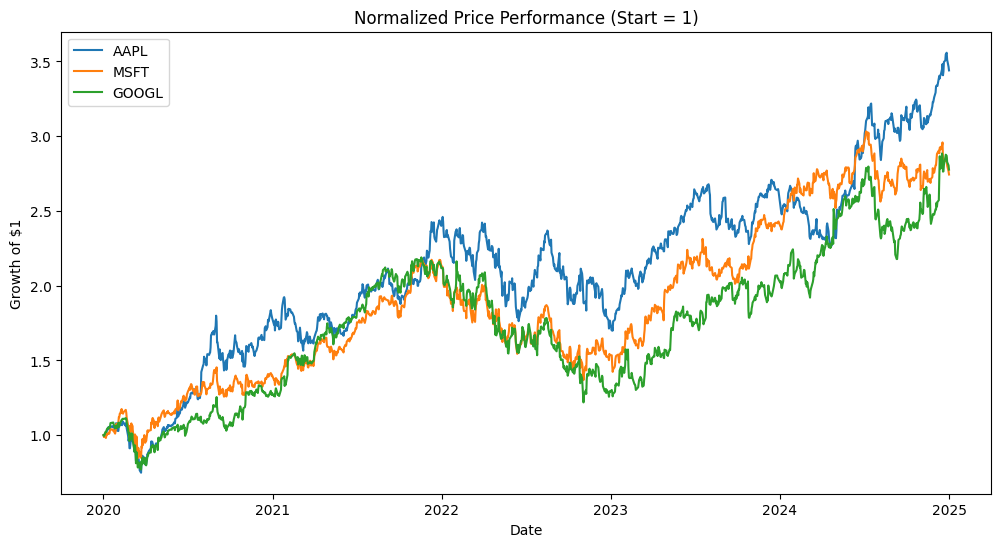

In [6]:
normalized = prices / prices.iloc[0]

plt.figure(figsize=(12,6))
for t in tickers:
    plt.plot(normalized[t], label=t)
plt.title("Normalized Price Performance (Start = 1)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

## 7. Computing daily returns

In [7]:
returns = prices.pct_change().dropna()
returns.head()

,AAPL,MSFT,GOOGL
Date,,,
2020-01-03,-0.009722,-0.012452,-0.005231
2020-01-06,0.007968,0.002585,0.026654
2020-01-07,-0.004703,-0.009118,-0.001931
2020-01-08,0.016086,0.015929,0.007118
2020-01-09,0.021241,0.012493,0.010498


## 8. Portfolio daily returns

In [8]:
portfolio_ret = returns.dot(weights)
portfolio_ret.head()

,0
Date,
2020-01-03,-0.009135
2020-01-06,0.012402
2020-01-07,-0.005251
2020-01-08,0.013044
2020-01-09,0.014744


## 9. Portfolio equity curve

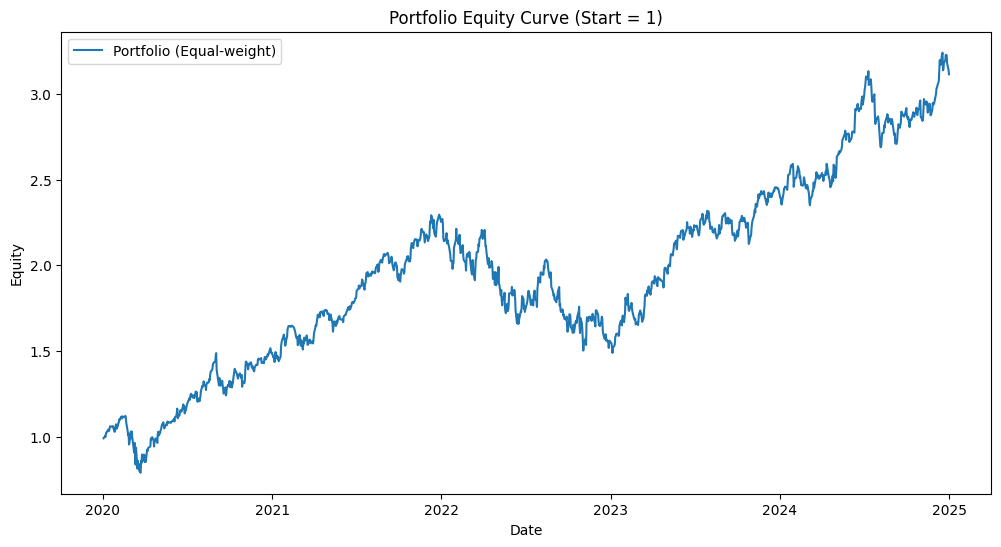

In [9]:
portfolio_equity = (1 + portfolio_ret).cumprod()

plt.figure(figsize=(12,6))
plt.plot(portfolio_equity, label="Portfolio (Equal-weight)")
plt.title("Portfolio Equity Curve (Start = 1)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()

## 10. Portfolio Volatility

In [10]:
vol_daily = portfolio_ret.std()
vol_annual = vol_daily * np.sqrt(252)

print("Daily Volatility:", vol_daily)
print("Annualized Volatility:", vol_annual)

Daily Volatility: 0.01788043358976437
Annualized Volatility: 0.28384308367513456


## 11. Check Diversification

In [11]:
corr = returns.corr()
corr

,AAPL,MSFT,GOOGL
AAPL,1.000000,0.748327,0.648932
MSFT,0.748327,1.000000,0.746182
GOOGL,0.648932,0.746182,1.000000


## 12. Drawdown Curve and Max Drawdown

In [ ]:
peak = portfolio_equity.cummax()
drawdown = portfolio_equity / peak - 1

plt.figure(figsize=(12,4))
plt.plot(drawdown)
plt.title("Portfolio Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()

print("Max Drawdown:", drawdown.min())

## 13. Compare Portfolio vs Each Single Stock

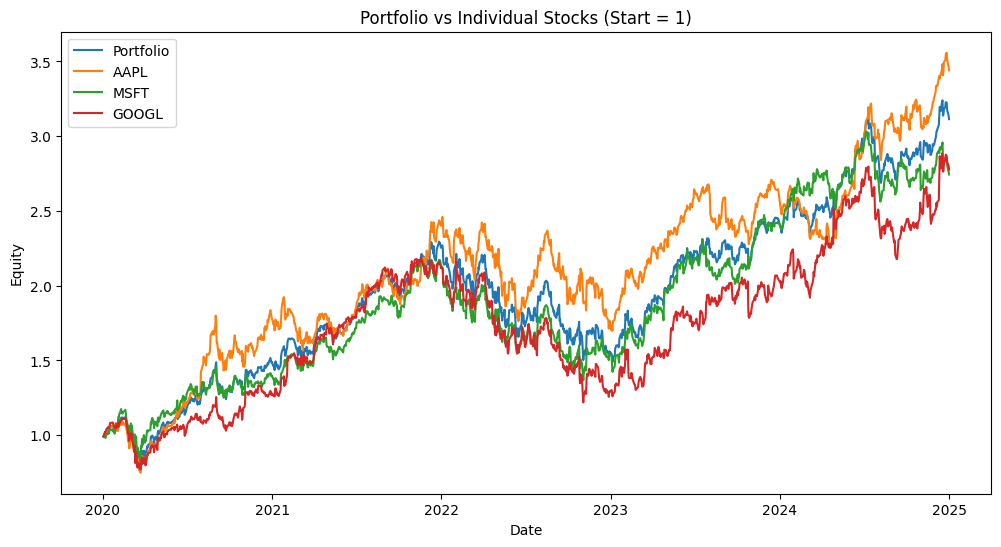

In [12]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_equity, label="Portfolio")

for t in tickers:
    eq_t = (1 + returns[t]).cumprod()
    plt.plot(eq_t, label=t)

plt.title("Portfolio vs Individual Stocks (Start = 1)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.show()

## 14. Metrics table (portfolio + each stock)

In [13]:
def max_drawdown_from_equity(equity):
    peak = equity.cummax()
    dd = equity/peak - 1
    return dd.min()

def sharpe(daily_returns):
    if daily_returns.std() == 0:
        return np.nan
    return np.sqrt(252) * daily_returns.mean() / daily_returns.std()

rows = []

# Portfolio metrics
rows.append({
    "Asset": "Portfolio",
    "Final Equity": float(portfolio_equity.iloc[-1]),
    "Vol (ann.)": float(portfolio_ret.std() * np.sqrt(252)),
    "Sharpe": float(sharpe(portfolio_ret)),
    "Max Drawdown": float(max_drawdown_from_equity(portfolio_equity))
})

# Individual stock metrics
for t in tickers:
    eq_t = (1 + returns[t]).cumprod()
    rows.append({
        "Asset": t,
        "Final Equity": float(eq_t.iloc[-1]),
        "Vol (ann.)": float(returns[t].std() * np.sqrt(252)),
        "Sharpe": float(sharpe(returns[t])),
        "Max Drawdown": float(max_drawdown_from_equity(eq_t))
    })

pd.DataFrame(rows)

,Asset,Final Equity,Vol (ann.),Sharpe,Max Drawdown
0,Portfolio,3.113609,0.283843,0.944689,-0.351177
1,AAPL,3.440023,0.316786,0.940356,-0.314273
2,MSFT,2.743592,0.304972,0.816241,-0.371485
3,GOOGL,2.776197,0.324989,0.792666,-0.443201
